In [1]:
import keras
from keras.layers import Input, Conv2D, Flatten, MaxPool2D, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from keras import models
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np
import cv2
import time
import glob, os 
from skimage import io, transform
import json

Using TensorFlow backend.


# Problem 1

Choose a small (< 3,000) image dataset for classification. Include the link where you have downloaded the pictures from.

---

In order for this to work, you need a kaggle account. With this, you can download the data set here [here](https://www.kaggle.com/ivanfel/honey-bee-pollen).

With this, we can read in the data at the path `/images`. This is where you must place the dataset after you download it.

In [2]:
path="images/"
imlist= glob.glob(os.path.join(path, '*.jpg'))

Now, we can read all the images, and shape them correctly. The function below reads all the images and returns the array and label for each corresponding label.

In [3]:
def dataset(file_list,size=(300,180),flattened=False):
    data = []
    for i, file in enumerate(file_list):
        image = io.imread(file)
        image = transform.resize(image, size, mode='constant')
        if flattened:
            image = image.flatten()

        data.append(image)

    labels = [1 if f.split("/")[-1][0] == 'P' else 0 for f in file_list]

    return np.array(data), np.array(labels)
X,Y=dataset(imlist)

With the images loaded and labeled, we can look at the shape of the data and target of the model.

In [4]:
print('Data:   ',X.shape)
print('Target: ',Y.shape)

Data:    (714, 300, 180, 3)
Target:  (714,)


Here, we see that we have 714 images that are RGB. 

Now lets look at an example from the dataset.

In [5]:
fig, axes = plt.subplots(1,2)
k=0
plt.sca(axes[0])
plt.imshow(X[k])
plt.title('Has Pollen'.format(k, Y[k]))

k=400
plt.sca(axes[1])
plt.imshow(X[k])
plt.title('No Pollen'.format(k, Y[k]));

*Goal*: Classify the bees that have pollen and those that do not.

## 1

Train a model from scratch using what little data you have without any regularization, to set a baseline for what can be achieved.

---

The first step in training the model is splitting the train and validation data.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=18)

partial_x_train, validation_x_train, partial_y_train, validation_y_train = train_test_split(
    x_train, y_train, test_size=0.15, random_state=18)

With this, we can compile a model composed of the convolution layers. 

In [7]:
verbose = 0
# input
input_layer = Input(shape=(300, 180, 3))

# conv layers
conv_layer1   = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
conv_layer1   = MaxPool2D( (2, 2), padding='same')(conv_layer1)

conv_layer2   = Conv2D(64, (3, 3), activation='relu')(conv_layer1)
conv_layer2   = MaxPool2D( (2, 2), padding='same')(conv_layer2)

conv_layer3   = Conv2D(128, (3, 3), activation='relu')(conv_layer2)
conv_layer3   = Conv2D(128, (3, 3), activation='relu')(conv_layer3)
conv_layer3   = MaxPool2D( (2, 2), padding='same')(conv_layer3)

conv_layer4   = Conv2D(256, (3, 3), activation='relu')(conv_layer3)
conv_layer4   = Conv2D(256, (3, 3), activation='relu')(conv_layer4)
conv_layer4   = MaxPool2D( (2, 2), padding='same')(conv_layer4)

# flatten and dense layers
flatten_layer = Flatten()(conv_layer3)
dense_layer   = Dense(512, activation='relu')(flatten_layer)

# output
output_layer  = Dense(1, activation='sigmoid')(dense_layer)

model_1 = Model(input_layer, output_layer)
model_1.compile(
    optimizer=RMSprop(lr=1e-4), 
    loss='binary_crossentropy',
    metrics=['accuracy'])
if verbose==1:
    print(model_1.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 180, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 180, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 90, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 88, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 44, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 42, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 70, 40, 128)       1475

In [8]:
epochs = 100
batch_size = 15
history_1 = model_1.fit(
    partial_x_train, 
    partial_y_train,
    validation_data=(validation_x_train, validation_y_train),
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=verbose
)

Train on 485 samples, validate on 86 samples
Epoch 1/100
485/485 [==============================] - 93s 193ms/step - loss: 0.6653 - acc: 0.6165 - val_loss: 0.5456 - val_acc: 0.7674
Epoch 2/100
485/485 [==============================] - 88s 182ms/step - loss: 0.4688 - acc: 0.8021 - val_loss: 0.4038 - val_acc: 0.8605
Epoch 3/100
485/485 [==============================] - 84s 172ms/step - loss: 0.3722 - acc: 0.8392 - val_loss: 0.4077 - val_acc: 0.8140
Epoch 4/100
485/485 [==============================] - 83s 172ms/step - loss: 0.3133 - acc: 0.8701 - val_loss: 0.3896 - val_acc: 0.8605
Epoch 5/100
485/485 [==============================] - 86s 176ms/step - loss: 0.2828 - acc: 0.8763 - val_loss: 0.3323 - val_acc: 0.8721
Epoch 6/100
485/485 [==============================] - 83s 171ms/step - loss: 0.2114 - acc: 0.9134 - val_loss: 0.3835 - val_acc: 0.8953
Epoch 7/100
485/485 [==============================] - 84s 172ms/step - loss: 0.2121 - acc: 0.9093 - val_loss: 0.3388 - val_acc: 0.8605
Epo

Epoch 60/100
485/485 [==============================] - 82s 170ms/step - loss: 8.2437e-07 - acc: 1.0000 - val_loss: 1.4485 - val_acc: 0.8721
Epoch 61/100
485/485 [==============================] - 85s 176ms/step - loss: 6.1006e-07 - acc: 1.0000 - val_loss: 1.4022 - val_acc: 0.8837
Epoch 62/100
485/485 [==============================] - 82s 169ms/step - loss: 2.0971e-07 - acc: 1.0000 - val_loss: 1.4260 - val_acc: 0.8721
Epoch 63/100
485/485 [==============================] - 83s 170ms/step - loss: 1.7414e-07 - acc: 1.0000 - val_loss: 1.4602 - val_acc: 0.8605
Epoch 64/100
485/485 [==============================] - 85s 175ms/step - loss: 1.2690e-07 - acc: 1.0000 - val_loss: 1.5482 - val_acc: 0.8721
Epoch 65/100
485/485 [==============================] - 83s 172ms/step - loss: 1.1833e-07 - acc: 1.0000 - val_loss: 1.5602 - val_acc: 0.8721
Epoch 66/100
485/485 [==============================] - 82s 170ms/step - loss: 1.1240e-07 - acc: 1.0000 - val_loss: 1.5476 - val_acc: 0.8605
Epoch 67/100


In [21]:
model_1.save_weights("part1-1.h5")
with open("history_1.json", "w") as fp:
    json.dump(history_1.history, fp)

In [2]:
with open("history_1.json") as fp:
    history = json.load(fp)


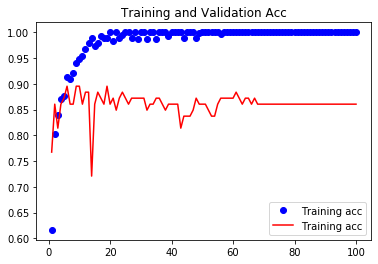

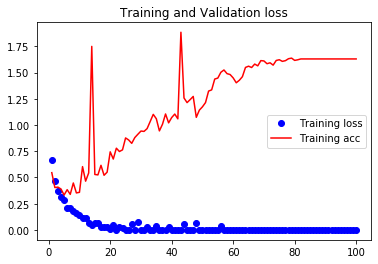

In [3]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r-', label='Training acc')
plt.legend()
plt.title('Training and Validation Acc')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Training acc')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

In [11]:
test_loss, test_acc = model_1.evaluate(x_test, y_test, steps=10)
print('The final test accuracy: ',test_acc)

10/10 [==============================] - 67s 7s/step
The final test accuracy:  0.8741258978843689


## 2

Use data augmentation to generate more training data from your existing training samples. Also add a Dropout layer to your model, right before the densely connected classifier.

In [12]:
# input
input_layer = Input(shape=(300, 180, 3))

# conv layers
conv_layer1   = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
conv_layer1   = MaxPool2D( (2, 2), padding='same')(conv_layer1)

conv_layer2   = Conv2D(64, (3, 3), activation='relu')(conv_layer1)
conv_layer2   = MaxPool2D( (2, 2), padding='same')(conv_layer2)

conv_layer3   = Conv2D(128, (3, 3), activation='relu')(conv_layer2)
conv_layer3   = Conv2D(128, (3, 3), activation='relu')(conv_layer3)
conv_layer3   = MaxPool2D( (2, 2), padding='same')(conv_layer3)

conv_layer4   = Conv2D(256, (3, 3), activation='relu')(conv_layer3)
conv_layer4   = Conv2D(256, (3, 3), activation='relu')(conv_layer4)
conv_layer4   = MaxPool2D( (2, 2), padding='same')(conv_layer4)

# flatten and dense layers
flatten_layer = Flatten()(conv_layer3)
flatten_layer = Dropout(0.5)(flatten_layer)
dense_layer   = Dense(512, activation='relu')(flatten_layer)

# output
output_layer  = Dense(1, activation='sigmoid')(dense_layer)

model_2 = Model(input_layer, output_layer)
model_2.compile(
    optimizer=RMSprop(lr=1e-4), 
    loss='binary_crossentropy',
    metrics=['accuracy'])
if verbose==1:
    print(model_2.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300, 180, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 300, 180, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 150, 90, 64)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 148, 88, 64)       36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 44, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 42, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 70, 40, 128)       1475

In [13]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(partial_x_train)
history_2 = model_2.fit_generator(
    datagen.flow(
        partial_x_train, 
        partial_y_train, 
        batch_size=batch_size
    ),
    steps_per_epoch=len(partial_x_train) / batch_size,
    epochs=epochs,
    verbose=verbose
)

TypeError: '<' not supported between instances of 'int' and 'range'

In [ ]:
model_2.save_weights("part1-2.h5")

In [ ]:
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r-', label='Training acc')
plt.legend()
plt.title('Training and Validation Acc')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Training acc')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

In [ ]:
test_loss, test_acc = model_2.evaluate(x_test, y_test, steps=10)
print('The final test accuracy: ',test_acc)

## Problem 2

For this problem you use the data in “admData.csv” on Canvas. This file contains the accumulative number of admitted students to a certain program with 5 annual start dates.

The data has seasonal behavior: the accumulative number of admissions is monotonically increasing during the interval between 2 start dates and then it resets once a new term starts as shown in figure 1.

The objective of the problem is to predict the accumulative number of admissions 7, 14, 21, 28, 35, 42, 49, 56, 63, and 70 days from the current date.

![Figure 1](Figure1.png)

i.e. on any given day, you need to forecast what the accumulative number of admissions will be in 1 week, 2 weeks, ... 10 weeks from that day.
You need to use 70% of the data for training, 15% for validation, and 15% (the most recent) for test.

## 1

Create a recurrent neural network model. Explore both GRU and LSTM layers.

---

In [ ]:
df = pd.read_csv(
    filepath_or_buffer="all_stocks_5yr.csv"
)